## Sentiment Analysis of Political Tweets
#### https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment
Includes some of my approaches and some that I found across sites like kaggle.

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical
from gensim import models
%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#loading data

data = pd.read_csv('./Sentiment.csv')
data = data[['text','sentiment']]

In [3]:
## helper functions

tkzr = TweetTokenizer()                
stop = stopwords.words('english')+['\n','\r','\t','rt']
lemmatizer = nltk.stem.WordNetLemmatizer()
puncts = string.punctuation

def clean(s):
    s = re.sub(r'http\S+','',s)
    s = s.translate(str.maketrans('','',puncts)).lower()
    s = [lemmatizer.lemmatize(word) for word in tkzr.tokenize(s) if word not in stop]
    return s

def clean_and_join(s):
    s = re.sub(r'http\S+','',s)
    s = s.translate(str.maketrans('','',puncts)).lower()
    s = [lemmatizer.lemmatize(word) for word in tkzr.tokenize(s) if word not in stop]
    return ' '.join(s)

### Using words (as features) and Naive Bayes Classifier

In [4]:
# Splitting the dataset into train and test set
X_train,X_test,y_train,y_test = train_test_split(data['text'],data['sentiment'],test_size = 0.2)
# Removing neutral sentiments
X_train = X_train[y_train!= "Neutral"]

Positive words


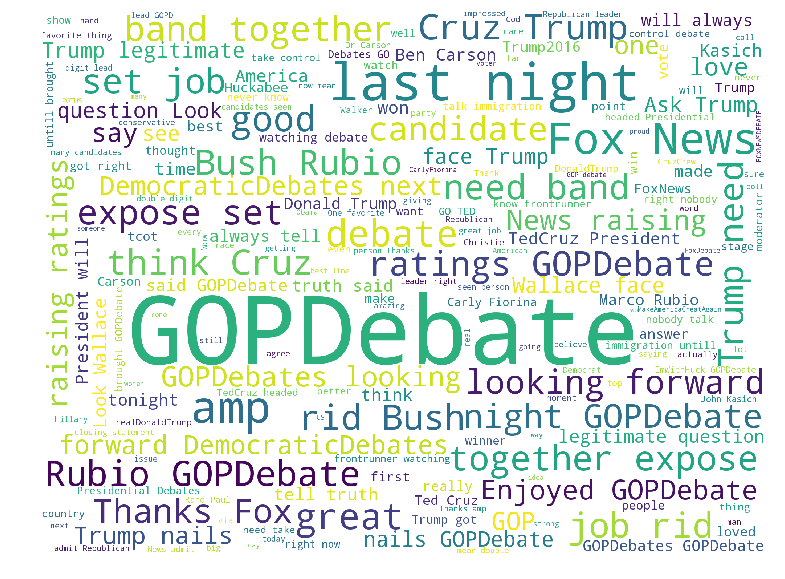

Negative words


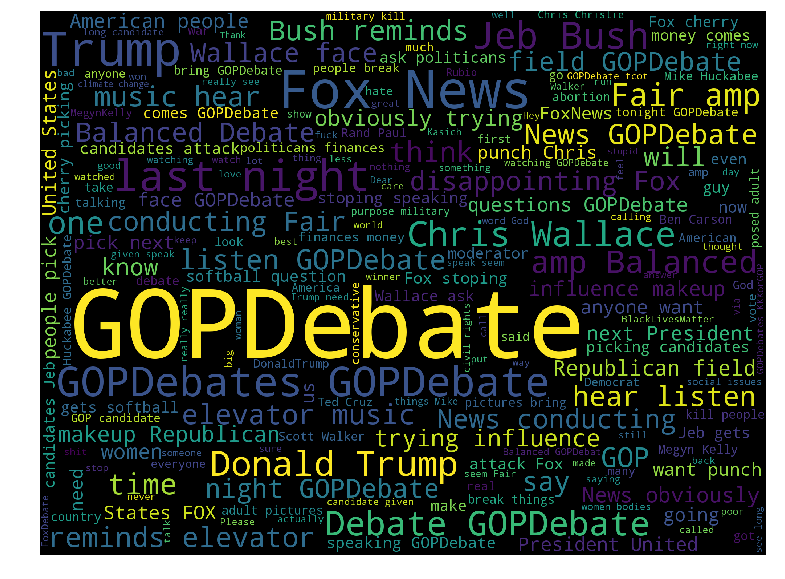

In [5]:
X_train_pos = X_train[y_train == 'Positive']
X_train_neg = X_train[y_train == 'Negative']

def draw_wordcloud(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word # not a url
                                and not word.startswith('@') # not a username
                                and word != 'RT' # not a retweet
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2000,
                      height=1500
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
draw_wordcloud(X_train_pos)
print("Negative words")
draw_wordcloud(X_train_neg,color='black')

In [6]:
tweets = []

for i in range(len(X_train)):
    words_cleaned = clean(X_train.iloc[i])
    tweets.append((words_cleaned,y_train.iloc[i]))

X_test_pos = X_test[y_test == 'Positive']
X_test_neg = X_test[y_test == 'Negative']

In [7]:
# Extracting word features
def get_words_in_tweets(tweets):
    all_words = []
    for (words,sent) in tweets:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
#draw_wordcloud(w_features)

In [8]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [9]:
neg_cnt = 0
pos_cnt = 0
for obj in X_test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in X_test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(X_test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(X_test_pos),pos_cnt))    

[Negative]: 1715/1648 
[Positive]: 440/1 


### Using word (as features) and LSTM RNN

In [10]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
data2 = data.copy()
data2 = data2[data2['sentiment']!='Neutral']
data2['text'] = data2['text'].apply(lambda x: clean_and_join(x))
data2['tokens'] = data2['text'].apply(lambda x: clean(x))
tokenizer.fit_on_texts(data2['text'].values)
X = tokenizer.texts_to_sequences(data2['text'].values)
X = pad_sequences(X)

In [11]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1], dropout=0.1))
model.add(LSTM(lstm_out, dropout_U=0.1, dropout_W=0.1))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.1, recurrent_dropout=0.1)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 128)           256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
Y = pd.get_dummies(data2['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3,random_state = 11)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7510, 22) (7510, 2)
(3219, 22) (3219, 2)


In [13]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1)
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("\nScore: %.2f" % (score))
print("Acc: %.2f" % (acc))

Epoch 1/10
7510/7510 [==============================] - 32s - loss: 0.4205 - acc: 0.8236    
Epoch 2/10
7510/7510 [==============================] - 25s - loss: 0.2978 - acc: 0.8726    
Epoch 3/10
7510/7510 [==============================] - 23s - loss: 0.2543 - acc: 0.8891    
Epoch 4/10
7510/7510 [==============================] - 23s - loss: 0.2225 - acc: 0.9029    
Epoch 5/10
7510/7510 [==============================] - 23s - loss: 0.1941 - acc: 0.9192    
Epoch 6/10
7510/7510 [==============================] - 23s - loss: 0.1713 - acc: 0.9294    
Epoch 7/10
7510/7510 [==============================] - 25s - loss: 0.1539 - acc: 0.9372    
Epoch 8/10
7510/7510 [==============================] - 24s - loss: 0.1379 - acc: 0.9427    
Epoch 9/10
7510/7510 [==============================] - 23s - loss: 0.1235 - acc: 0.9458    
Epoch 10/10
3219/3219 [==============================] - 4s     

Score: 0.80
Acc: 0.83


In [14]:
validation_size = 1000

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.81
acc: 0.83


In [15]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

### Using Word2Vec, ANN & LightGBM

In [16]:
data2 = data.copy()
data2 = data2[data2['sentiment']!='Neutral']
data2['text'] = data2['text'].apply(lambda x: clean_and_join(x))
data2['tokens'] = data2['text'].apply(lambda x: clean(x))
model = models.Word2Vec(data2['tokens'].values, size=100, window=5, min_count=5, workers=4, hs=1, alpha=0.05, iter=100)

In [17]:
vectors = []
for sentence in data2['tokens'].values:
    s = None
    counter = 0
    for word in sentence:
        if s is None:
            try:
                s = model.wv[word]
                counter = 1
            except:
                pass
        else:       
            try:
                s = ((s*counter) + model.wv[word])/float(counter+1)
                counter = counter + 1
            except:
                pass
    if s is None:
        s = np.zeros(100)
    vectors.append(s)

In [18]:
def get_model(n_feat):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=n_feat))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(.5))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [19]:
Y = pd.get_dummies(data2['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(np.array(vectors),Y,test_size = 0.3,random_state = 11)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7510, 100) (7510, 2)
(3219, 100) (3219, 2)


In [20]:
batch_size = 32
dmodel = get_model(100)
dmodel.fit(X_train,Y_train, epochs=10,batch_size=batch_size)

Epoch 1/10
7510/7510 [==============================] - 1s - loss: 0.4707 - acc: 0.7947     
Epoch 2/10
7510/7510 [==============================] - 0s - loss: 0.4019 - acc: 0.8316     
Epoch 3/10
7510/7510 [==============================] - 0s - loss: 0.3674 - acc: 0.8456     
Epoch 4/10
7510/7510 [==============================] - 0s - loss: 0.3435 - acc: 0.8559     
Epoch 5/10
7510/7510 [==============================] - 0s - loss: 0.3293 - acc: 0.8651     
Epoch 6/10
7510/7510 [==============================] - 0s - loss: 0.3132 - acc: 0.8708     
Epoch 7/10
7510/7510 [==============================] - 0s - loss: 0.2969 - acc: 0.8787     
Epoch 8/10
7510/7510 [==============================] - 0s - loss: 0.2828 - acc: 0.8850     
Epoch 9/10
7510/7510 [==============================] - 0s - loss: 0.2708 - acc: 0.8877     
Epoch 10/10
7510/7510 [==============================] - 0s - loss: 0.2584 - acc: 0.8915     


In [21]:
validation_size = 1000

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = dmodel.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.44
acc: 0.84


In [22]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = dmodel.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 48.275862068965516 %
neg_acc 92.34629861982434 %


In [23]:
import lightgbm as lgb
target = data2['sentiment'].apply(lambda x: 1 if x=='Positive' else 0).values
X_train, X_test, Y_train, Y_test = train_test_split(np.array(vectors),target,test_size = 0.3,random_state = 11)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
validation_size = 1500
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
dtrain = lgb.Dataset(X_train, Y_train)
dval = lgb.Dataset(X_validate, Y_validate)
scale_pos = len(Y_train[Y_train==0])/len(Y_train[Y_train==1])
params = {
    'num_leaves' : 256,
    'learning_rate':0.03,
    'metric':'auc',
    'objective':'binary',
    'early_stopping_round': 40,
    'max_depth':8,
    'bagging_fraction':0.5,
    'feature_fraction':0.6,
    'bagging_seed':2017,
    'feature_fraction_seed':2017,
    'verbose' : 1,
    'scale_pos_weight':scale_pos
}

(7510, 100) (7510,)
(3219, 100) (3219,)


In [24]:
clf_lgb = lgb.train(params, dtrain,num_boost_round=500,valid_sets=(dtrain,dval),verbose_eval=100)

[100]	training's auc: 0.985486	valid_1's auc: 0.842367
[200]	training's auc: 0.991237	valid_1's auc: 0.847563
[300]	training's auc: 0.994517	valid_1's auc: 0.848408
[400]	training's auc: 0.996257	valid_1's auc: 0.847289
[500]	training's auc: 0.997029	valid_1's auc: 0.845019


In [25]:
pos,neg,pos_cnt,neg_cnt=0,0,0,0
for i in range(len(X_test)):
    if Y_test[i]==1:
        pos_cnt+=1
        if clf_lgb.predict(X_test[i].reshape(1,100))>=0.5:
            pos+=1
    else:
        neg_cnt+=1
        if clf_lgb.predict(X_test[i].reshape(1,100))<0.5:
            neg+=1

print("Pos Acc: ",pos/pos_cnt*100,"%")
print("Neg Acc: ",neg/neg_cnt*100,"%")

Pos Acc:  50.41782729805014 %
Neg Acc:  93.52941176470588 %


### Using TFIDF Vectorizer and Multiple Classification Algorithms

In [26]:
data2 = data.copy()
data2 = data2[data2['sentiment']!='Neutral']
data2['text'] = data2['text'].apply(lambda x: clean_and_join(x))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop)
target = data2['sentiment'].apply(lambda x: 1 if x=='Positive' else 0).values
X_train, X_test, Y_train, Y_test = train_test_split(list(data2['text'].values),target,test_size = 0.3,random_state = 11)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [28]:
Classifiers = [
    SVC(kernel="rbf", C=0.001, probability=False),
    LogisticRegression(C=0.001,solver='liblinear',max_iter=100),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GaussianNB(),
    MultinomialNB()]

In [29]:
X_dense_train = X_train.toarray()
X_dense_test = X_test.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(X_train,Y_train)
        pred = fit.predict(X_test)
    except Exception:
        fit = classifier.fit(X_dense_train,Y_train)
        pred = fit.predict(X_dense_test)
    accuracy = accuracy_score(pred,Y_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))
    pos,neg,pos_cnt,neg_cnt=0,0,0,0
    for i in range(len(X_dense_test)):
        if Y_test[i]==1:
            pos_cnt+=1
            if pred[i]==1:
                pos+=1
        else:
            neg_cnt+=1
            if pred[i]==0:
                neg+=1
    print("Pos Acc: ",pos/pos_cnt*100,"%")
    print("Neg Acc: ",neg/neg_cnt*100,"%")

Accuracy of SVC is 0.795899347623
Pos Acc:  0.0 %
Neg Acc:  100.0 %
Accuracy of LogisticRegression is 0.795899347623
Pos Acc:  0.0 %
Neg Acc:  100.0 %
Accuracy of KNeighborsClassifier is 0.831314072693
Pos Acc:  48.401826484018265 %
Neg Acc:  92.03747072599532 %
Accuracy of DecisionTreeClassifier is 0.819509164337
Pos Acc:  54.794520547945204 %
Neg Acc:  88.91491022638563 %
Accuracy of RandomForestClassifier is 0.859894377136
Pos Acc:  44.596651445966515 %
Neg Acc:  96.60421545667447 %
Accuracy of AdaBoostClassifier is 0.834420627524
Pos Acc:  44.1400304414003 %
Neg Acc:  93.52068696330991 %
Accuracy of GaussianNB is 0.696178937558
Pos Acc:  64.9923896499239 %
Neg Acc:  70.80405932864949 %
Accuracy of MultinomialNB is 0.836905871389
Pos Acc:  24.04870624048706 %
Neg Acc:  98.98516783762685 %


## Summary

One thing that anyone could notice is that this problem doesn't demand extensive EDA. Sure, we can plot worldclouds to better recognize words which maybe more important than the others but focusing on only the lexical features may not produce much accurate models (Not that contextual feature helped here much. I am looking at you Word2Vec!). Although, I think the dramatic difference between the size of positive and negative tweets in the dataset maybe the cause of the bad performance of the models while classifying the positive tweets. Better dataset is required before committing to a more indepth analysis of political tweets. May need to think more about how should I preprocess the tweets. Also, in future, I may need to create a separate module just to deal with sarcastic/ironical tweets.